## Imports

In [1]:
import pandas as pd
import numpy as np
from pingouin import rcorr
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col
from utils.formatting import normalize_string, get_formula
from scipy.stats import norm
from statstests.tests import shapiro_francia

## Loading Files

In [2]:
df_student = pd.read_csv("datasets/student_performance.csv")

In [3]:
# Dataset Visualization
df_student

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,Yes,9,1,91.0
1,4,82,No,4,2,65.0
2,8,51,Yes,7,2,45.0
3,5,52,Yes,5,2,36.0
4,7,75,No,8,5,66.0
...,...,...,...,...,...,...
9995,1,49,Yes,4,2,23.0
9996,7,64,Yes,8,5,58.0
9997,6,83,Yes,8,5,74.0
9998,9,97,Yes,7,0,95.0


In [4]:
# Formatting DataFrame columns to simplify interactions
df_student.columns = normalize_string(df_student.columns)
df_student.columns

Index(['hours_studied', 'previous_scores', 'extracurricular_activities',
       'sleep_hours', 'sample_question_papers_practiced', 'performance_index'],
      dtype='object')

In [5]:
# Inspecting DataFrame structure
df_student.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   hours_studied                     10000 non-null  int64  
 1   previous_scores                   10000 non-null  int64  
 2   extracurricular_activities        10000 non-null  object 
 3   sleep_hours                       10000 non-null  int64  
 4   sample_question_papers_practiced  10000 non-null  int64  
 5   performance_index                 10000 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 468.9+ KB


In [ ]:
# Checking for missing values (NA) in rows
na_count = df_student.isna().any(axis=1).sum()
print(f"Number of rows with missing values: {na_count}")

Number of rows with missing values: 0


## Descriptive Statistics
> * Analysing the distribution of the dataset variables

In [7]:
# Non-numeric variables
df_student.select_dtypes(include=object).describe()

,extracurricular_activities
count,10000
unique,2
top,No
freq,5052


In [8]:
# Numeric variables
df_student.describe()

,hours_studied,previous_scores,sleep_hours,sample_question_papers_practiced,performance_index
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,4.992900,69.445700,6.530600,4.583300,55.224800
std,2.589309,17.343152,1.695863,2.867348,19.212558
min,1.000000,40.000000,4.000000,0.000000,10.000000
25%,3.000000,54.000000,5.000000,2.000000,40.000000
50%,5.000000,69.000000,7.000000,5.000000,55.000000
75%,7.000000,85.000000,8.000000,7.000000,71.000000
max,9.000000,99.000000,9.000000,9.000000,100.000000


([0, 1, 2, 3, 4],
 [Text(0, 0, 'hours_studied'),
  Text(1, 0, 'previous_scores'),
  Text(2, 0, 'sleep_hours'),
  Text(3, 0, 'sample_question_papers_practiced'),
  Text(4, 0, 'performance_index')])

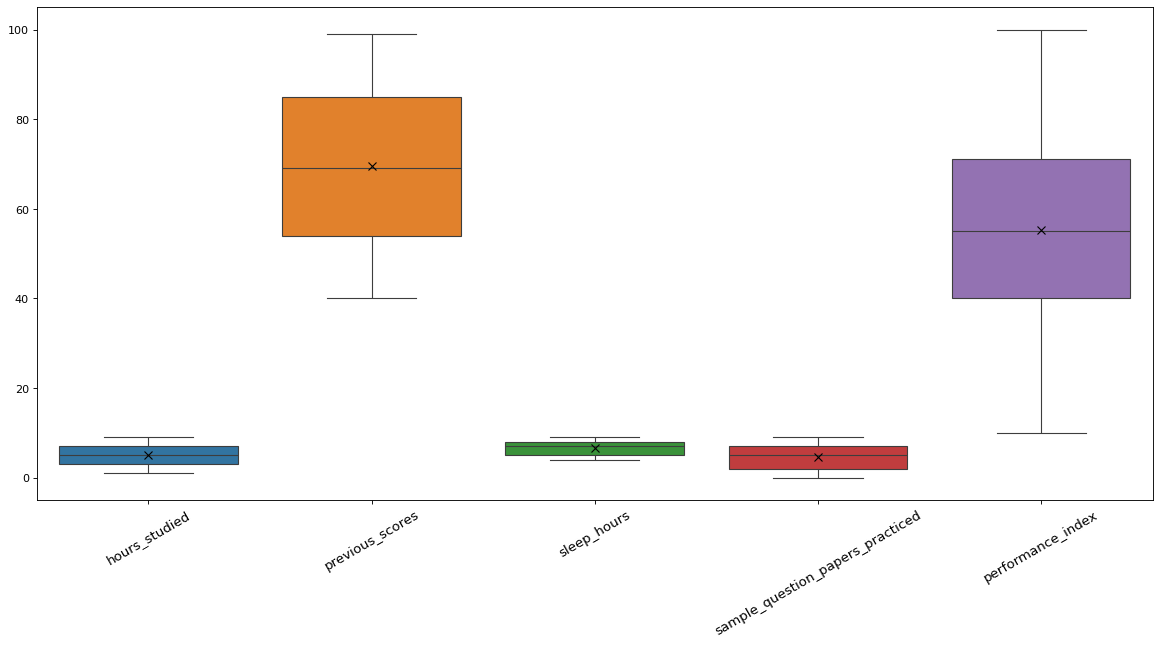

In [9]:
# Box-plot visualization for numeric variables
plt.figure(figsize=(18,8), dpi=80)

sns.boxplot(
    data=df_student,
    showmeans=True,
    meanprops={
        "marker":"x",
        "markeredgecolor":"black",
        "markersize":8
    }
)

plt.xticks(rotation=30, size=12)

> * Correlation helps to understand the association degree between two variables and provides insights that can help explain some models' behavior and patterns, such as multicollinearity (the removal of variables caused by redundancy).

In [10]:
rcorr(
    df_student,
    method="pearson",
    upper="pval",
    stars=True,
    pval_stars={0.01: "***", 0.05: "**", 0.1: "*"},
)

,hours_studied,previous_scores,sleep_hours,sample_question_papers_practiced,performance_index
hours_studied,-,,,*,***
previous_scores,-0.012,-,,,***
sleep_hours,0.001,0.006,-,,***
sample_question_papers_practiced,0.017,0.008,0.004,-,***
performance_index,0.374,0.915,0.048,0.043,-


Text(0.5, 1.0, 'Correlation Matrix')

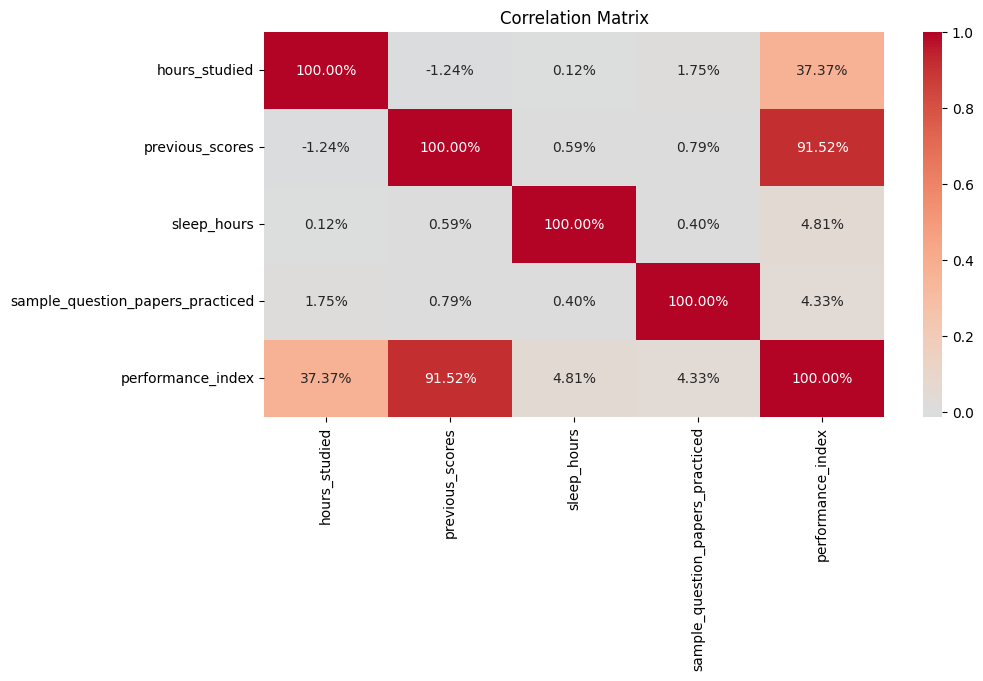

In [11]:
# Correlation Matrix visualization
plt.figure(figsize=(10, 5), dpi=100)

corr_matrix = df_student.select_dtypes(exclude=object).corr()

ax = sns.heatmap(
    data=corr_matrix,
    cmap="coolwarm",
    center=0,
    annot=corr_matrix.map(lambda x: f"{x:.2%}"),
    fmt="",
    annot_kws={"size":10}
)

plt.title("Correlation Matrix", fontsize=12)

> * None of the explanatory variables exhibit a high degree of correlation with each other, indicating that the phenomenon of multicollinearity is unlikely to occur.

> * All explanatory variables have a statistically significant association with the outcome variable `performance_index`, indicating that they will likely remain in the final model.

## OLS Model

In [12]:
formula = get_formula(df_student, endog="performance_index")

print(formula)

performance_index ~ hours_studied + previous_scores + extracurricular_activities + sleep_hours + sample_question_papers_practiced


In [13]:
model = smf.ols(data=df_student, formula=formula).fit()

> Obs.: Since `extracurricular_activities` is a qualitative variable with only two categories, the statsmodels algorithm will automatically apply the one-hot encoding procedure, with the `No` category set as reference.

In [14]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      performance_index   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                 1.757e+05
Date:                Mon, 25 Nov 2024   Prob (F-statistic):               0.00
Time:                        20:39:26   Log-Likelihood:                -21307.
No. Observations:               10000   AIC:                         4.263e+04
Df Residuals:                    9994   BIC:                         4.267e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                           -34.0756      0.127   -268.010      0.000     -34.325     -33.826
extracurricular_activities[T.Yes]     0.6129      0.041     15.029      0.000       0.533       0.693
hours_studied                         2.8530      0.008    362.353      0.000       2.838       2.868
previous_scores                       1.0184      0.001    866.450      0.000       1.016       1.021
sleep_hours                           0.4806      0.012     39.972      0.000       0.457       0.504
sample_question_papers_practiced      0.1938      0.007     27.257      0.000       0.180       0.208
==============================================================================
Omnibus:                        3.851   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.146   Jarque-Bera (JB):                4.036
Skew:                           0.013   Prob(JB):                        0.133
Kurtosis:                       3.095   Cond. No.                         452.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

> * All explanatory variables are statistically significant, eliminating the need for the stepwise procedure.

## Diagnosis
> - The lack of adherence to the normal distribution of model residuals significantly compromises the construction of confidence intervals with predictable purposes. Tests like the Shapiro-Francia provides a tool to validate adherence and the Box-Cox normalization technique can be very useful in improving the model's predictive capability

In [ ]:
# Test for Adherence to Normality of Residuals
sf_test = shapiro_francia(model.resid)

print(10*"-")

if sf_test["p-value"] > 0.05:
    print("H0: There is adherence to normality")
else:
    print("H1: There is no adherence to normality")

method  :  Shapiro-Francia normality test
statistics W  :  0.9997423432149402
statistics z  :  0.9583455485066418
p-value  :  0.1689442714333197
----------
H0: There is adherence to normality


Text(0.5, 1.0, 'Model Residuals Distribution')

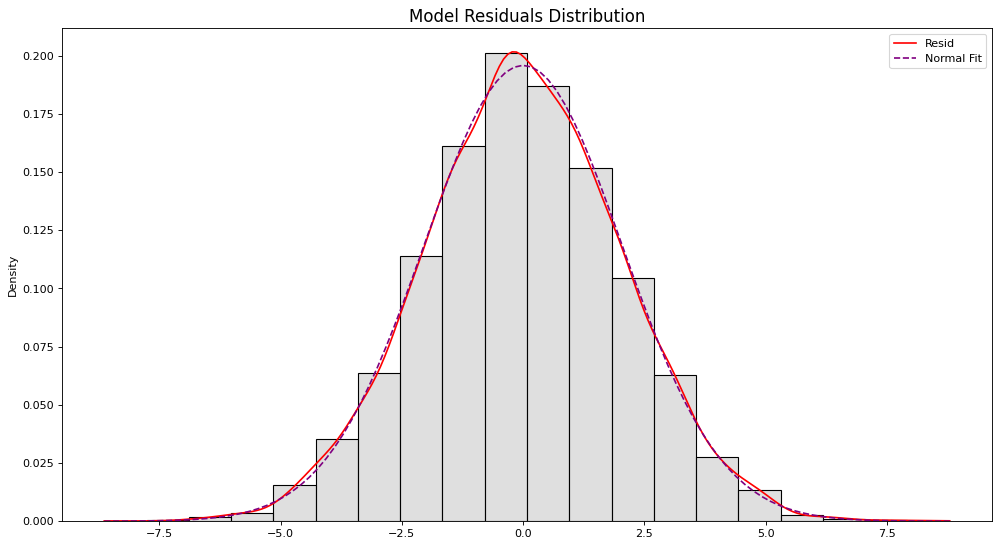

In [ ]:
# Visual comparison between normal distribution and residuals
plt.figure(figsize=(15,8), dpi=80)

sns.histplot(
    data=model.resid,
    bins=20,
    color='silver',
    kde=True,
    stat="density",
    line_kws={"label":"Resid"}
).lines[0].set_color("red")

mu, sigma = norm.fit(model.resid)

x_norm = np.linspace(model.resid.min(), model.resid.max(), 100)

y_norm = norm.pdf(x_norm, mu, sigma)

plt.plot(
    x_norm,
    y_norm,
    color='purple',
    ls = '--',
    label = "Normal Fit",
)

plt.legend()
plt.title("Model Residuals Distribution", size=15)

> * The adherence to normality of the model residuals eliminates the need for applying the Box-Cox normalization.

## Results

In [17]:
summary_col(
    results=[model],
    model_names=["OLS Model"],
    stars=True,
    include_r2=True
)

,OLS Model
Intercept,-34.0756***
,(0.1271)
extracurricular_activities[T.Yes],0.6129***
,(0.0408)
hours_studied,2.8530***
,(0.0079)
previous_scores,1.0184***
,(0.0012)
sleep_hours,0.4806***
,(0.0120)


#### Conclusion
> * An R-squared of 0.98 indicates a very high prediction capability, meaning we can expect the predicted values to be very close to the actual values presented in the DataFrame for `performance_index`.

> * The two variables with the highest impact on `performance_index`, when increasing by one unit while keeping all others constant, are `hours_studied` and `previous_scores`.

> * Analyzing the coefficient for `hours_studied` and keeping all other variables constant, it is estimated that each additional hour of study has an impact of 2.85 on the target variable `performance_index`.

> * All explanatory variables have a positive impact on `performance_index` as they increase.

> * The behavior of the `NO` category in `extracurricular_activities` is captured by the negative value of the intercept.

In [18]:
# Visual comparison between actual values and predicted values provided by the OLS model
df_student[["performance_index"]].assign(performance_index_predict=model.predict(), resid=model.resid)

,performance_index,performance_index_predict,resid
0,91.0,91.852009,-0.852009
1,65.0,63.157787,1.842213
2,45.0,45.052832,-0.052832
3,36.0,36.551201,-0.551201
4,66.0,67.091339,-1.091339
...,...,...,...
9995,23.0,21.603410,1.396590
9996,58.0,56.501461,1.498539
9997,74.0,72.998729,1.001271
9998,95.0,94.366183,0.633817
